# Simulations for the sensitivity analysis

The sensitivity analysis tests the sensitivity of outcomes to a variety of dimensions:
* ventilation efficiency
* efficiency of masks
* adherence to voluntary testing (testing rate)
* adherence to class size reductions (reduzed class size)
* sensitivity of antigen tests
* additional contacts between students through firendships
* virus transmissibility
* Variations in the age dependence of the transmission risk
* Variations in the contact weight

In [2]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from scseirx import analysis_functions as af
import data_creation_functions as dcf
import data_analysis_functions as daf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

In [1]:
# we run simulations only for the minimum number of screnarios required to save
# time. The minimum number of parameter combinations is indicated in this dict
min_cutoffs = {'ventilation_efficiency':16,
               'testing_rate':18,
               'mask_efficiency':14,
               'test_sensitivity':18,
               'reduced_class_size':16,
               'added_friendship_contacts':16}

## Simulation settings

In [3]:
with open('params/sensitivity_analysis_measures.json', 'r') as fp:
    measures = json.load(fp)
with open('params/sensitivity_analysis_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
with open('params/sensitivity_analysis_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

## Ventilation efficiency

### Screening parameters

In [4]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'ventilation_efficiency.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification']) \
           for i, row in screening_params.iterrows()\
           for st in school_types]

params = params[0: min_cutoffs['ventilation_efficiency'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 80 different parameter combinations


### Simulation function

In [5]:
def run_ventilation_efficiency(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and ventilation_modification. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod)
    
    return ensmbl_results

### Running the simulations

In [16]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/ventilation_efficiency'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_ventilation_efficiency,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'ventilation_efficiency_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 80/80 [4:16:20<00:00, 192.26s/it]  


CPU times: user 3.61 s, sys: 770 ms, total: 4.38 s
Wall time: 4h 16min 21s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,student,None,None,False,False,0.0,0.2,2.0,346.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
1,primary,student,None,None,False,False,0.0,0.2,0.0,346.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
2,primary,student,None,None,False,False,0.0,0.2,3.0,346.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [20]:
dst = '../../data/sensitivity_analysis/simulation_results/ventilation_efficiency'
results = pd.read_csv(join(dst, 'ventilation_efficiency_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_ventilation_efficiency(results)

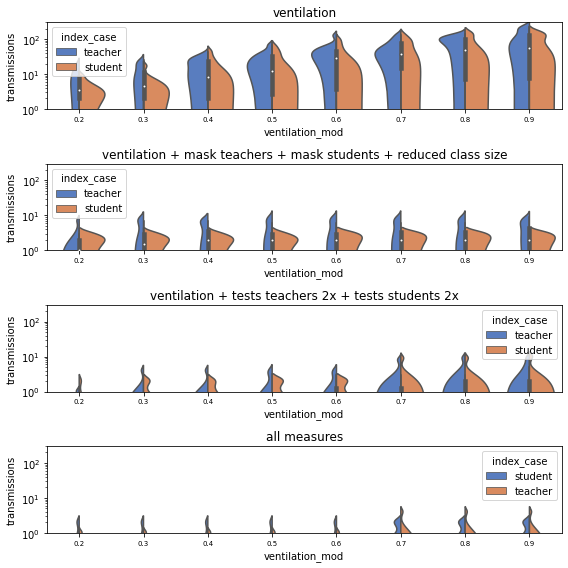

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="ventilation_mod", y="transmissions", hue="index_case",
                        data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Mask efficiency

### Screening parameters

In [4]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'mask_efficiency.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['m_efficiency_exhale'],
           row['m_efficiency_inhale']) \
           for i, row in screening_params.iterrows()\
           for st in school_types
           ]

params = params[0: min_cutoffs['mask_efficiency'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 70 different parameter combinations


### Simulation function

In [5]:
def run_mask_efficiency(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, mask_efficiency_exhale and
        mask_efficiency_inhale. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        m_efficiency_exhale, m_efficiency_inhale = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod,
            mask_efficiency_exhale=m_efficiency_exhale,
            mask_efficiency_inhale=m_efficiency_inhale)
    
    return ensmbl_results

### Running the simulations

In [6]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/mask_efficiency'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_mask_efficiency,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'mask_efficiency_exhale',
              'mask_efficiency_inhale']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'mask_efficiency_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 70/70 [2:11:03<00:00, 112.34s/it]  


CPU times: user 2.61 s, sys: 537 ms, total: 3.15 s
Wall time: 2h 11min 4s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,mask_efficiency_exhale,mask_efficiency_inhale,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,student,None,None,True,True,0.0,1.0,0.1,0.3,...,same_day_antigen,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.005,0.3
1,primary,student,None,None,True,True,0.0,1.0,0.1,0.3,...,same_day_antigen,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.005,0.3
2,primary,student,None,None,True,True,0.0,1.0,0.1,0.3,...,same_day_antigen,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [6]:
dst = '../../data/sensitivity_analysis/simulation_results/mask_efficiency'
results = pd.read_csv(join(dst, 'mask_efficiency_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_mask_efficiency(results)

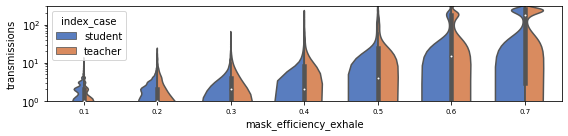

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

sns.violinplot(x="mask_efficiency_exhale", y="transmissions", hue="index_case",
                    data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=7)
ax.set_yscale('log')
ax.set_ylim(1, 300)
fig.tight_layout()

## Testing rate

### Screening parameters

In [9]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'testing_rate.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['s_test_rate'],
           row['t_test_rate']) \
           for i, row in screening_params.iterrows()\
           for st in school_types
           ]

params = params[0: min_cutoffs['testing_rate'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 90 different parameter combinations


### Simulation function

In [10]:
def run_testing_rate(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and s_testing_rate and t_testing_rate. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        s_testing_rate, t_testing_rate = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod,
            s_testing_rate=s_testing_rate,
            t_testing_rate=t_testing_rate)
    
    return ensmbl_results

### Running the simulations

In [11]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/testing_rate'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_testing_rate,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'student_testing_rate', 'teacher_testing_rate']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'testing_rate_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 90/90 [3:30:24<00:00, 140.28s/it]  


CPU times: user 3.68 s, sys: 507 ms, total: 4.18 s
Wall time: 3h 30min 26s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,student_testing_rate,teacher_testing_rate,...,test_type,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,teacher,7,7,False,False,0.0,1.0,0.9,0.9,...,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
1,primary,teacher,7,7,False,False,0.0,1.0,0.9,0.9,...,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
2,primary,teacher,7,7,False,False,0.0,1.0,0.9,0.9,...,same_day_antigen,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [12]:
dst = '../../data/sensitivity_analysis/simulation_results/testing_rate'
results = pd.read_csv(join(dst, 'testing_rate_{}.csv'.format(N_runs)))
dcf.set_measure_packages_testing_rate(results)

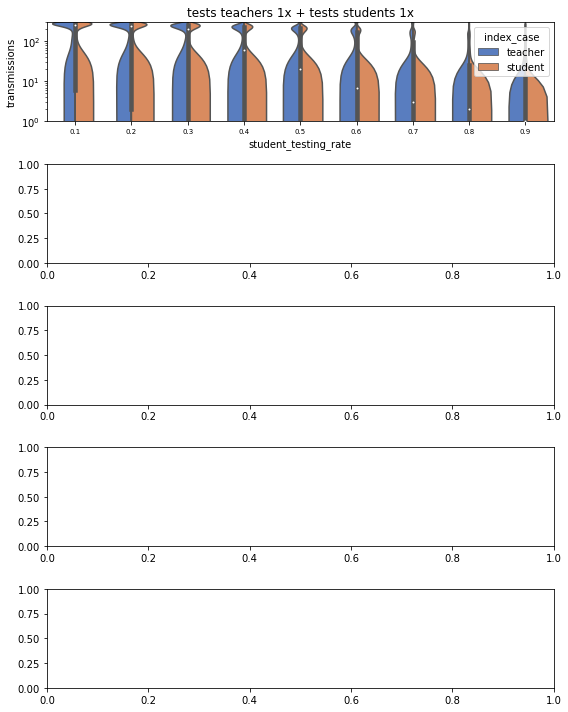

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="student_testing_rate", y="transmissions", hue="index_case",
                        data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Test sensitivity

### Screening parameters

In [14]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'test_sensitivity.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['ttype']) \
           for i, row in screening_params.iterrows()\
           for st in school_types
           ]

params = params[0: min_cutoffs['test_sensitivity'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 90 different parameter combinations


### Simulation function

In [15]:
def run_test_sensitivity(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and ttype, which encodes the test 
        sensitivity. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        ttype = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, ttype=ttype)
    
    return ensmbl_results

### Running the simulations

In [16]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/test_sensitivity'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_test_sensitivity,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'test_type',]
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'test_sensitivity_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 90/90 [3:24:44<00:00, 136.49s/it]  


CPU times: user 3.75 s, sys: 378 ms, total: 4.13 s
Wall time: 3h 24min 45s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,test_type,N_diagnostic_tests,...,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.1,0.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
1,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.1,0.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
2,primary,student,7,7,False,False,0.0,1.0,same_day_antigen0.1,23.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [17]:
dst = '../../data/sensitivity_analysis/simulation_results/test_sensitivity'
results = pd.read_csv(join(dst, 'test_sensitivity_{}.csv'.format(N_runs)))
# note: the test sensitivity simulations use the same function to assign
# measure scenarios, since the scenarios are the same
dcf.set_measure_packages_testing_rate(results)

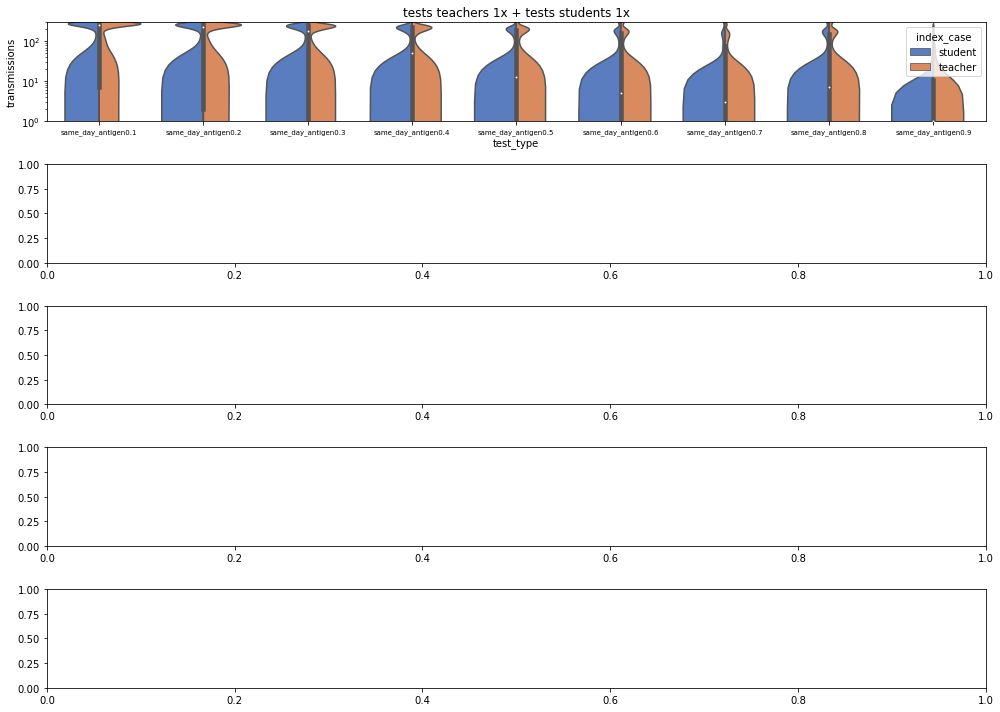

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10))

order = ['same_day_antigen0.1', 'same_day_antigen0.2', 'same_day_antigen0.3',
         'same_day_antigen0.4', 'same_day_antigen0.5', 'same_day_antigen0.6',
         'same_day_antigen0.7', 'same_day_antigen0.8', 'same_day_antigen0.9']

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="test_type", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax,
                   order=order)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Reduced class size

### Screening parameters

In [19]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'reduced_class_size.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification']) \
           for i, row in screening_params.iterrows()\
           for st in school_types
           ]

params = params[0: min_cutoffs['reduced_class_size'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 80 different parameter combinations


### Simulation function

In [20]:
def run_reduced_class_size(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and class_size_reduction. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, 
            class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod)
    
    return ensmbl_results

### Running the simulations

In [21]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/reduced_class_size'
dst = '../../data/sensitivity_analysis/simulation_results/reduced_class_size'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_reduced_class_size,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod',]
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'reduced_class_size_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 80/80 [2:23:33<00:00, 107.67s/it]  


CPU times: user 3.19 s, sys: 346 ms, total: 3.53 s
Wall time: 2h 23min 34s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,student,None,None,False,False,0.2,1.0,1.0,370.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
1,primary,student,None,None,False,False,0.2,1.0,1.0,370.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3
2,primary,student,None,None,False,False,0.2,1.0,3.0,370.0,...,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [22]:
dst = '../../data/sensitivity_analysis/simulation_results/reduced_class_size'
results = pd.read_csv(join(dst, 'reduced_class_size_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_reduced_class_size(results)

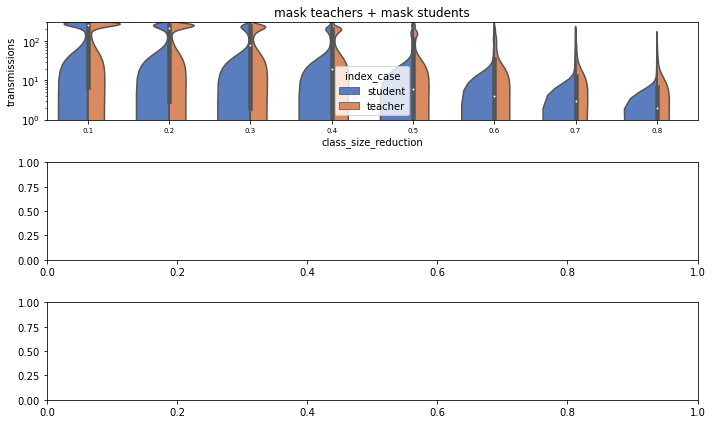

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="class_size_reduction", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Added friendship contacts

### Screening parameters

In [24]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'added_friendship_contacts.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['added_friendship_contacts']) \
           for i, row in screening_params.iterrows()\
           for st in school_types
           ]

params = params[0: min_cutoffs['added_friendship_contacts'] * len(school_types)]
print('there are {} different parameter combinations'\
      .format(len(params)))

there are 80 different parameter combinations


### Simulation function

In [25]:
def run_added_friendship_contacts(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and friendship_ratio, which encodes the
        ratio of students per class that will have added contacts to students
        from other classes. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        friendship_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, friendship_ratio=friendship_ratio)
    
    return ensmbl_results

### Running the simulations

In [26]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/added_friendship_contacts'
dst = '../../data/sensitivity_analysis/simulation_results/added_friendship_contacts'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_added_friendship_contacts,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'friendship_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'added_friendship_contacts_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 80/80 [5:23:43<00:00, 242.80s/it]   


CPU times: user 3.89 s, sys: 424 ms, total: 4.31 s
Wall time: 5h 23min 45s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,friendship_ratio,N_diagnostic_tests,...,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount,contact_weight
0,primary,student,None,None,False,False,0.0,1.0,0.05,2.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,-0.005,0.3
1,primary,student,None,None,False,False,0.0,1.0,0.05,2.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,-0.005,0.3
2,primary,student,None,None,False,False,0.0,1.0,0.05,2.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,-0.005,0.3


### Evaluate the simulations

In [27]:
dst = '../../data/sensitivity_analysis/simulation_results/added_friendship_contacts'
results = pd.read_csv(join(dst, 'added_friendship_contacts_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_added_friendship_contacts(results)

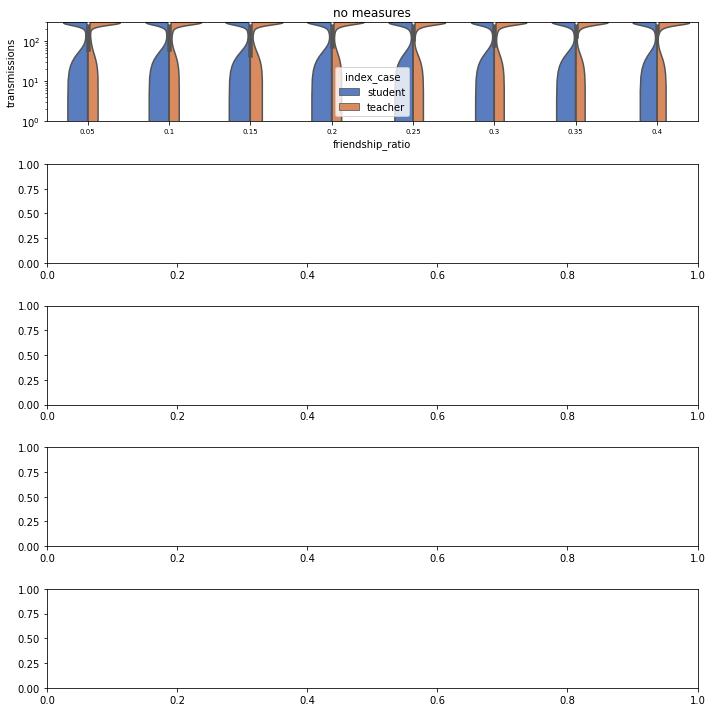

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="friendship_ratio", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 300)
    ax.set_title(measure)
fig.tight_layout()

## Worst case

### Screening parameters

In [43]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'worst_case.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['m_efficiency_exhale'],
           row['m_efficiency_inhale'],
           row['s_test_rate'],
           row['t_test_rate'],
           row['ttype'],
           row['added_friendship_contacts']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [58]:
def run_worst_case(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, ventilation_modification, 
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate,
        t_testing_rate, ttype (encoding test sensitivity) and friendship_ratio.
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate, \
        t_testing_rate, ttype, friendship_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            mask_efficiency_exhale=mask_efficiency_exhale,
            mask_efficiency_inhale=mask_efficiency_inhale,
            s_testing_rate=s_testing_rate, t_testing_rate=t_testing_rate,
            ttype=ttype, friendship_ratio=friendship_ratio)
    
    return ensmbl_results

### Running the simulations

In [60]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/worst_case'
dst = '../../data/sensitivity_analysis/simulation_results/worst_case'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_worst_case,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'worst_case_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 18/18 [00:21<00:00,  1.22s/it]

CPU times: user 207 ms, sys: 124 ms, total: 331 ms
Wall time: 22.1 s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,7,7,False,False,0.3,0.8,7.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0
1,primary,student,7,7,False,False,0.3,0.8,1.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0
2,primary,student,7,7,False,False,0.3,0.8,1.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.0,0.0,0.0


### Evaluate the simulations

In [ ]:
dst = '../../data/sensitivity_analysis/simulation_results/worst_case'
results = pd.read_csv(join(dst, 'worst_case_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_worst_case(results)

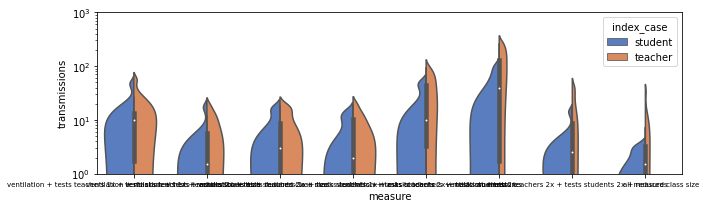

In [83]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.violinplot(x="measure", y="transmissions", hue="index_case",
               data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=7)
ax.set_yscale('log')
ax.set_ylim(1, 1000)
fig.tight_layout()

### Aggregate the results

In [86]:
src = '../../data/sensitivity_analysis/simulation_results/worst_case'
dst = src
for stype in school_types:
    print(stype)
    data = daf.get_data(stype, src)
    data['measure'] = np.nan
    data['student_screen_interval'] = data['student_screen_interval'].fillna('never')
    data['teacher_screen_interval'] = data['teacher_screen_interval'].fillna('never')
    dcf.set_measure_packages_worst_case(data)
    data.to_csv(join(dst, '{}_combined_ensembles.csv'.format(stype)), index=False)

primary
primary_dc
lower_secondary
lower_secondary_dc
upper_secondary
secondary


## Worst case and vaccinations

### Screening parameters

In [88]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'worst_case_and_vaccinations.csv'))
screening_params = screening_params
params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['m_efficiency_exhale'],
           row['m_efficiency_inhale'],
           row['s_test_rate'],
           row['t_test_rate'],
           row['ttype'],
           row['added_friendship_contacts'],
           row['student_vaccination_ratio'],
           row['teacher_vaccination_ratio'],
           row['family_member_vaccination_ratio']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [12]:
def run_worst_case_and_vaccinations(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, ventilation_modification, 
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate,
        t_testing_rate, ttype (encoding test sensitivity), friendship_ratio,
        student_vaccination_ratio, teacher_vaccination_ratio and
        family_member_vaccination_ratio.
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        mask_efficiency_exhale, mask_efficiency_inhale, s_testing_rate, \
        t_testing_rate, ttype, friendship_ratio, student_vaccination_ratio, \
        teacher_vaccination_ratio, family_member_vaccination_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            mask_efficiency_exhale=mask_efficiency_exhale,
            mask_efficiency_inhale=mask_efficiency_inhale,
            s_testing_rate=s_testing_rate, t_testing_rate=t_testing_rate,
            ttype=ttype, friendship_ratio=friendship_ratio,
            student_vaccination_ratio=student_vaccination_ratio,
            teacher_vaccination_ratio=teacher_vaccination_ratio,
            family_member_vaccination_ratio=family_member_vaccination_ratio)
    
    return ensmbl_results

### Running the simulations

In [13]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/worst_case'
dst = '../../data/sensitivity_analysis/simulation_results/worst_case_and_vaccinations'

number_of_cores = psutil.cpu_count(logical=True)
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_worst_case_and_vaccinations,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'worst_case_and_vaccinations_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 108/108 [3:11:35<00:00, 106.44s/it] 


CPU times: user 4.86 s, sys: 813 ms, total: 5.68 s
Wall time: 3h 11min 36s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,N_diagnostic_tests,N_family_members,...,test_type,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,7,7,False,False,0.3,0.8,2.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.5,0.8,0.6
1,primary,student,7,7,False,False,0.3,0.8,1.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.5,0.8,0.6
2,primary,student,7,7,False,False,0.3,0.8,0.0,357.0,...,same_day_antigen0.4,0.5,0.5,1.0,0.8,0.6,0.2,0.5,0.8,0.6


### Evaluate the simulations

In [13]:
dst = '../../data/sensitivity_analysis/simulation_results/worst_case_and_vaccinations'
results = pd.read_csv(join(dst, 'worst_case_and_vaccinations_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_worst_case(results)

In [47]:
data = results
data[(data['ventilation_mod'] == 0.8) & \
                  (data['student_mask'] == False) & \
                  (data['teacher_mask'] == False) & \
                  #(data['student_screen_interval'] == 7) & \
                  #(data['teacher_screen_interval'] == 7) & \
                  #(data['class_size_reduction'] == 0.3)
    ]

,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,contact_weight,N_diagnostic_tests,...,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount


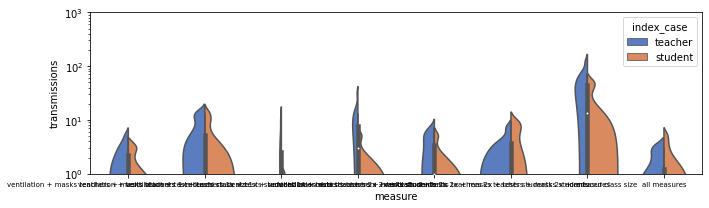

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))

sns.violinplot(x="measure", y="transmissions", hue="index_case",
               data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=7)
ax.set_yscale('log')
ax.set_ylim(1, 1000)
fig.tight_layout()

### Aggregate the results

In [89]:
src = '../../data/sensitivity_analysis/simulation_results/worst_case_and_vaccinations'
dst = src
for stype in school_types:
    print(stype)
    data = daf.get_data(stype, src)
    data['measure'] = np.nan
    data['student_screen_interval'] = data['student_screen_interval'].fillna('never')
    data['teacher_screen_interval'] = data['teacher_screen_interval'].fillna('never')
    dcf.set_measure_packages_worst_case(data)
    data.to_csv(join(dst, '{}_combined_ensembles.csv'.format(stype)), index=False)

primary
primary_dc
lower_secondary
lower_secondary_dc
upper_secondary
secondary


## Age dependent transmission risk

### Screening parameters

In [41]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary']
#school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'age_dependent_transmission_risk.csv'))
params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['age_transmission_discount']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]
print('there are {} parameter combinations'.format(len(params)))

there are 180 parameter combinations


### Simulation function

In [42]:
def run_age_dependent_transmission_risk(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, ventilation_modification, 
        and age_transmission_discount. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        age_transmission_discount = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,
            simulation_params, school_characteristics, contact_network_src,
            dst, index_case, s_screen_interval=s_screen_interval,\
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            age_transmission_discount=age_transmission_discount)
    
    return ensmbl_results

### Running the simulations

In [ ]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/age_dependent_transmission_risk'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_age_dependent_transmission_risk,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'age_transmission_discount']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'age_dependent_transmission_risk_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

### Evaluate the simulations

In [28]:
reload(dcf)
dst = '../../data/sensitivity_analysis/simulation_results/age_dependent_transmission_risk'
results = pd.read_csv(join(dst, 'age_dependent_transmission_risk_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_age_dependent_transmission_risk(results)

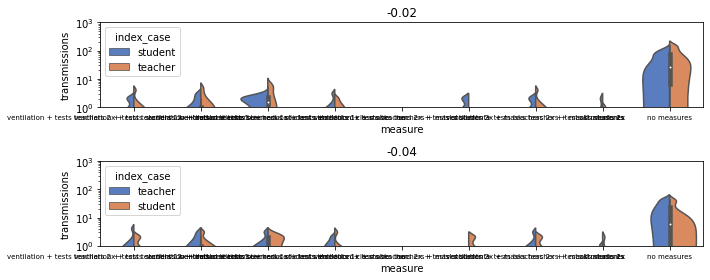

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
order = list(results['measure'].unique())

for ax, atd in zip(axes.flatten(), results['age_transmission_discount'].unique()):
    subset = results[results['age_transmission_discount'] == atd]
    sns.violinplot(x="measure", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax,
                   order=order)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000)
    ax.set_title(atd)
fig.tight_layout()

## Contact weight

### Screening parameters

In [29]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
#school_types = ['primary', 'primary_dc', 'lower_secondary',
#                'lower_secondary_dc', 'upper_secondary', 'secondary']
school_types = ['upper_secondary']
school_types.reverse()
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'contact_weight.csv'))
screening_params = screening_params
params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['contact_weight']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]
print('there are {} parameter combinations'.format(len(params)))

there are 36 parameter combinations


In [25]:
# secondary
missing_params = [
    (500, 'secondary', 'student', None, None, False, False, 0.0, 1.0, 0.34),
    (500, 'secondary', 'student', 3, 3, True, True, 0.5, 0.36, 0.34),
    (500, 'secondary', 'teacher', None, None, False, False, 0.0, 1.0, 0.34),
    (500, 'secondary', 'teacher', 3, 3, False, False, 0.5, 0.36, 0.34),
    (500, 'secondary', 'teacher', 3, 3, True, True, 0.5, 0.36, 0.34),
    (500, 'secondary', 'student', None, None, False, False, 0.0, 1.0, 0.26),
    (500, 'secondary', 'teacher', None, None, False, False, 0.0, 1.0, 0.26)
]

In [33]:
# upper_secondary
missing_params = [
    (500, 'upper_secondary', 'teacher', 7, 7, False, False, 0.0, 0.36, 0.26),
    (500, 'upper_secondary', 'student', 3, 3, False, False, 0.0, 0.36, 0.26),
    (500, 'upper_secondary', 'teacher', 3, 3, False, False, 0.0, 0.36, 0.26),
    (500, 'upper_secondary', 'student', 7, 7, True, True, 0.0, 0.36, 0.26),
    (500, 'upper_secondary', 'teacher', 7, 7, True, True, 0.0, 0.36, 0.26)
    
]

### Simulation function

In [34]:
def run_contact_weight(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction, ventilation_modification, 
        and contact weight. These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        contact_weight = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,
            simulation_params, school_characteristics, contact_network_src,
            dst, index_case, s_screen_interval=s_screen_interval,\
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            contact_weight=contact_weight)
    
    return ensmbl_results

### Running the simulations

In [35]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/contact_weight'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_contact_weight,
                        iterable=missing_params), total=len(missing_params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'contact_weight']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'contact_weight_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 5/5 [13:35<00:00, 163.13s/it]

CPU times: user 183 ms, sys: 116 ms, total: 299 ms
Wall time: 13min 35s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,contact_weight,N_diagnostic_tests,...,student_testing_rate,teacher_testing_rate,base_transmission_risk_multiplier,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio,age_transmission_discount
0,upper_secondary,teacher,7,7,True,True,0.0,0.36,0.26,0.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005
1,upper_secondary,teacher,7,7,True,True,0.0,0.36,0.26,0.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005
2,upper_secondary,teacher,7,7,True,True,0.0,0.36,0.26,0.0,...,1.0,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0,-0.005


### Evaluate the simulations

In [28]:
reload(dcf)
dst = '../../data/sensitivity_analysis/simulation_results/contact_weight'
results = pd.read_csv(join(dst, 'contact_weight_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
# re-uses the function for the age-dependent transmission risk, because the
# simulated scenarios are the same
dcf.set_measure_packages_age_dependent_transmission_risk(results)

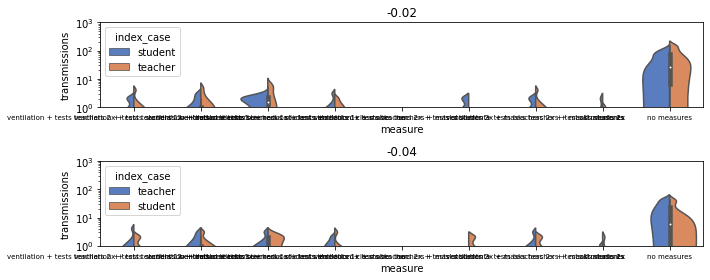

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
order = list(results['measure'].unique())

for ax, cw in zip(axes.flatten(), results['contact_weight_'].unique()):
    subset = results[results['contact_weight_'] == cw]
    sns.violinplot(x="measure", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax,
                   order=order)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000)
    ax.set_title(atd)
fig.tight_layout()

## Transmissibility

### Screening parameters

In [27]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 10
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary'][0:1]
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'transmissibility.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['class_size_reduction'],
           row['ventilation_modification'],
           row['base_transmission_risk_multiplier']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

### Simulation function

In [28]:
def run_transmissibility(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters N_runs, 
        school_type, index_case, s_screen_interval, t_screen_interval, s_mask,
        t_mask, class_size_reduction and base_transmission_risk_multiplier. 
        These parameters are passed to the simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval, \
        student_mask, teacher_mask, class_size_reduction, ventilation_mod, \
        base_transmission_risk_multiplier = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask,class_size_reduction=class_size_reduction,
            ventilation_mod=ventilation_mod, 
            base_transmission_risk_multiplier=base_transmission_risk_multiplier)
    
    return ensmbl_results

### Running the simulations

In [29]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/sensitivity_analysis/simulation_results/transmissibility'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run_transmissibility,
                        iterable=params), total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'class_size_reduction',
              'ventilation_mod', 'base_transmission_risk_multiplier']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'transmissibility_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 140/140 [02:35<00:00,  1.11s/it]

CPU times: user 1.64 s, sys: 237 ms, total: 1.88 s
Wall time: 2min 36s


,school_type,index_case,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,class_size_reduction,ventilation_mod,base_transmission_risk_multiplier,N_diagnostic_tests,...,undetected_infections,test_type,student_testing_rate,teacher_testing_rate,mask_efficiency_exhale,mask_efficiency_inhale,friendship_ratio,student_vaccination_ratio,teacher_vaccination_ratio,family_member_vaccination_ratio
0,primary,student,None,None,False,False,0.0,1.0,0.9,16.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
1,primary,student,None,None,False,False,0.0,1.0,0.9,3.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0
2,primary,student,None,None,False,False,0.0,1.0,0.9,16.0,...,0.0,same_day_antigen,1.0,1.0,0.5,0.7,0.0,0.0,0.0,0.0


### Evaluate the simulations

In [30]:
dst = '../../data/sensitivity_analysis/simulation_results/transmissibility'
results = pd.read_csv(join(dst, 'transmissibility_{}.csv'.format(N_runs)))
results['student_screen_interval'] = results['student_screen_interval']\
    .replace({np.nan:'never'})
results['teacher_screen_interval'] = results['teacher_screen_interval']\
    .replace({np.nan:'never'})
dcf.set_measure_packages_added_friendship_contacts(results)

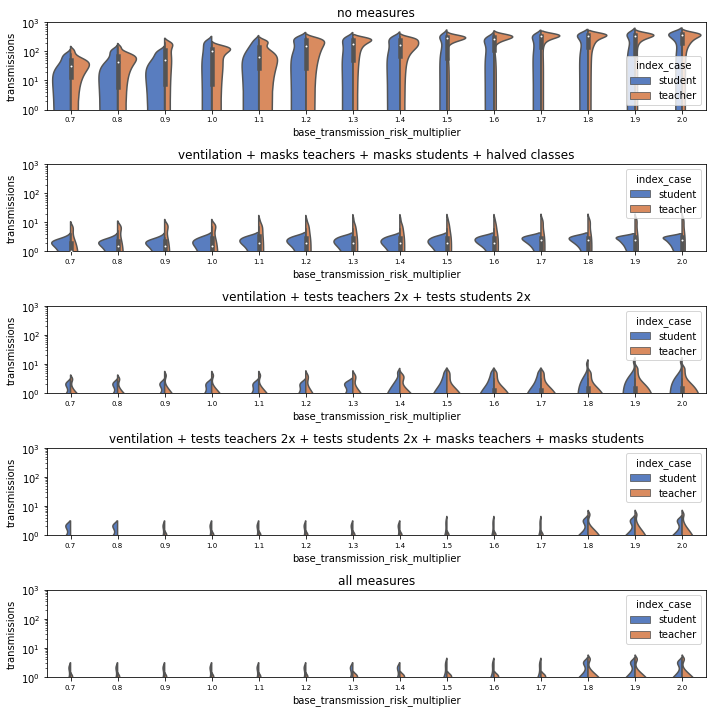

In [32]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for ax, measure in zip(axes.flatten(), results['measure'].unique()):
    subset = results[results['measure'] == measure]
    sns.violinplot(x="base_transmission_risk_multiplier", y="transmissions", hue="index_case",
                   data=subset, palette="muted", split=True, ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000)
    ax.set_title(measure)
fig.tight_layout()